In [1]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('/kaggle/input/hatespeechdatasetbalanced-reduce-50k/HateSpeechDatasetBalanced_reduced_50k.csv')

# Display the first few rows of the CSV file
df.head()


,Content,Label,clean_text
0,i am looking for them a lot of hay on top of t...,1,i am looking for them a lot of hay on top of t...
1,reply smile of course you can copy off of it i...,0,reply smile of course you can copy off of it i...
2,sorry i am sorry for the where are you i treat...,0,sorry i am sorry for the where are you i treat...
3,my touch not gods anointed hey the only thing ...,0,my touch not gods anointed hey the only thing ...
4,i do not like your attitude and the where are ...,1,i do not like your attitude and the where are ...


In [2]:
df_clean = df.drop(columns=["Content"])

In [3]:
df_clean.head()

,Label,clean_text
0,1,i am looking for them a lot of hay on top of t...
1,0,reply smile of course you can copy off of it i...
2,0,sorry i am sorry for the where are you i treat...
3,0,my touch not gods anointed hey the only thing ...
4,1,i do not like your attitude and the where are ...


In [4]:
from sklearn.model_selection import train_test_split

# Split into training and temp (which will be split into validation and test)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['clean_text'].tolist(), df['Label'].tolist(), test_size=0.3, random_state=42
)

# Split temp into validation and test sets
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"Testing samples: {len(test_texts)}")

Training samples: 35000
Validation samples: 7500
Testing samples: 7500


In [5]:
# Use a pipeline as a high-level helper
from transformers import pipeline

# Initialize the pipeline with the GPU if available
pipe = pipeline("text-classification", model="roberta-base")

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [6]:
# Load model directly
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [8]:
# Tokenize the data
def tokenize_texts(texts, tokenizer, max_length=512):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

In [9]:
# Datasets Encoding (Tokenizing)
train_encodings = tokenize_texts(train_texts, tokenizer)
val_encodings = tokenize_texts(val_texts, tokenizer)
test_encodings = tokenize_texts(test_texts, tokenizer)

In [10]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels))

In [11]:
# Batch the datasets
batch_size = 16
train_dataset = train_dataset.shuffle(len(train_texts)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss_fn, metrics=[metrics])

In [14]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),

    # Updated ModelCheckpoint to save in TensorFlow format
    tf.keras.callbacks.ModelCheckpoint(
        'best_model',  # Saves the model in TensorFlow's native format
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        save_format='tf'  # Save in TensorFlow's format (not HDF5)
    )
]


In [15]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[callbacks]
)

Epoch 1/10
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1728043414.873918      76 service.cc:145] XLA service 0x7fa03463a6a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728043414.873978      76 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1728043415.060068      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2188/2188 [==============================] - 2743s 1s/step - loss: 0.4369 - accuracy: 0.8015 - val_loss: 0.3601 - val_accuracy: 0.8440
Epoch 2/10
2188/2188 [==============================] - 2621s 1s/step - loss: 0.3219 - accuracy: 0.8638 - val_loss: 0.3402 - val_accuracy: 0.8541
Epoch 3/10
2188/2188 [==============================] - 2547s 1s/step - loss: 0.2401 - accuracy: 0.9059 - val_loss: 0.3832 - val_accuracy: 0.8500
Epoch 4/10
2188/2188 [==============================] - 2552s 1s/step - loss: 0.1858 - accuracy: 0.9310 - val_loss: 0.6101 - val_accuracy: 0.8017
Epoch 5/10
2188/2188 [==============================] - 2552s 1s/step - loss: 0.1939 - accuracy: 0.9272 - val_loss: 0.4510 - val_accuracy: 0.8459


In [16]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc}")


469/469 [==============================] - 149s 285ms/step - loss: 0.3551 - accuracy: 0.8521
Test Accuracy: 0.8521333336830139


In [17]:
# Plot training & validation loss and accuracy
def plot_history(history):
    # Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

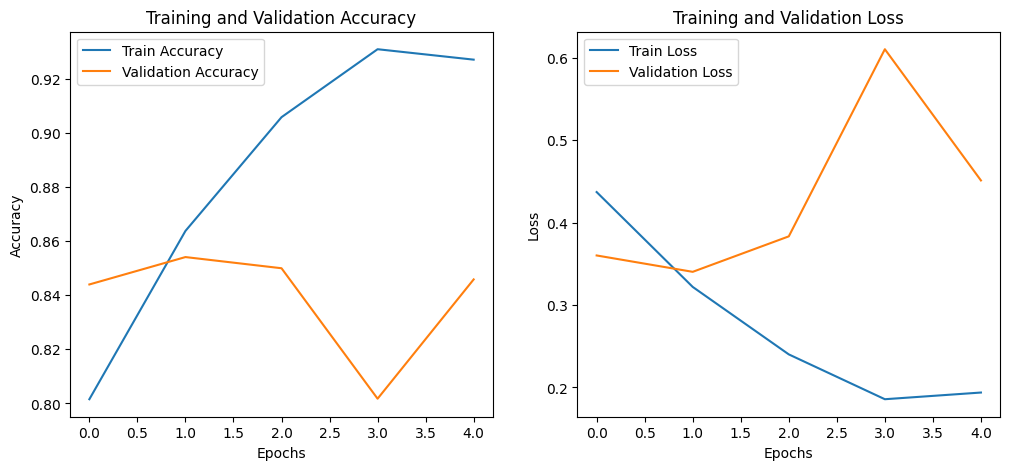

In [18]:
# Plot training history
plot_history(history)

In [21]:
# Predictions using Test dataset
predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions.logits, axis=1)  # Get predicted classes
y_true = test_labels  # Ground truth labels

# Convert to NumPy arrays for easier indexing
y_true_np = np.array(y_true)
y_pred_np = np.array(y_pred)


469/469 [==============================] - 132s 281ms/step


In [22]:
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_true_np, y_pred_np)

# Print confusion matrix
print(f"Confusion Matrix:\n{cm}")

# Classification report for precision, recall, F1-score
print(classification_report(y_true_np, y_pred_np))


Confusion Matrix:
[[3174  639]
 [ 470 3217]]
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      3813
           1       0.83      0.87      0.85      3687

    accuracy                           0.85      7500
   macro avg       0.85      0.85      0.85      7500
weighted avg       0.85      0.85      0.85      7500



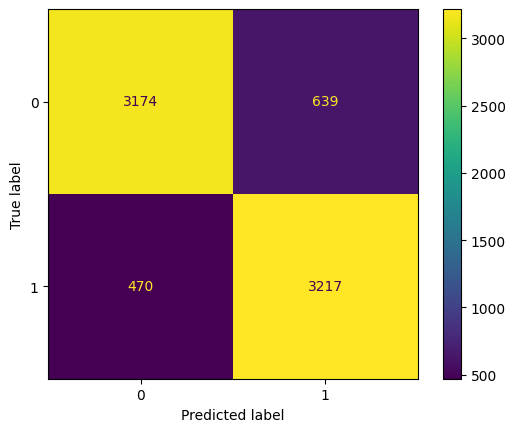

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_true_np, y_pred_np)
plt.show()


In [23]:
# Identify False Positives (predicted positive, but actual negative)
false_positives = np.where((y_pred_np == 1) & (y_true_np == 0))

# Identify False Negatives (predicted negative, but actual positive)
false_negatives = np.where((y_pred_np == 0) & (y_true_np == 1))

# Print the indices of False Positives and False Negatives
print(f"False Positives indices: {false_positives}")
print(f"False Negatives indices: {false_negatives}")


False Positives indices: (array([   5,   20,   26,   39,   40,   43,   48,   50,   55,   66,   76,
         80,   98,  111,  113,  135,  139,  160,  177,  184,  186,  224,
        238,  243,  254,  255,  256,  258,  264,  268,  272,  284,  293,
        314,  315,  319,  328,  360,  361,  372,  376,  395,  405,  409,
        415,  424,  426,  453,  457,  485,  489,  492,  522,  523,  535,
        539,  553,  562,  570,  591,  597,  599,  622,  624,  633,  636,
        675,  682,  686,  692,  705,  706,  714,  731,  759,  760,  774,
        776,  801,  803,  805,  821,  841,  844,  889,  923,  936,  947,
        958,  969,  986,  991,  992, 1006, 1007, 1012, 1018, 1031, 1032,
       1050, 1051, 1061, 1062, 1078, 1082, 1100, 1122, 1153, 1159, 1162,
       1165, 1190, 1192, 1212, 1218, 1244, 1248, 1284, 1287, 1307, 1329,
       1332, 1338, 1339, 1345, 1382, 1387, 1402, 1432, 1449, 1452, 1460,
       1464, 1465, 1470, 1515, 1524, 1530, 1540, 1544, 1546, 1554, 1555,
       1581, 1588, 1592, 

In [24]:
# Display false positive and negative samples
for i in false_positives[0]:
    print(f"False Positive Sample: {test_texts[i]}, True Label: {y_true[i]}, Predicted: {y_pred[i]}")

# Display false negative samples
for i in false_negatives[0]:
    print(f"False Negative Sample: {test_texts[i]}, True Label: {y_true[i]}, Predicted: {y_pred[i]}")


False Positive Sample: does smoking dope harm your ability to read or are you and duncan just chronically stupid read what the guy i what a slut responding to said cretin honestly, True Label: 0, Predicted: 1
False Positive Sample: let the ancient greece by the side you confuse the arabic with turkish it is easily to pass me like person who deliberately stirs up trouble because you are just older turkish madams are far away different from arabic, True Label: 0, Predicted: 1
False Positive Sample: retweet mr there can only be one drug so stop trying kat, True Label: 0, Predicted: 1
False Positive Sample: its not my fault you support gun control, True Label: 0, Predicted: 1
False Positive Sample: you are extremely monstrous oh yes it s because you are a weirdo, True Label: 0, Predicted: 1
False Positive Sample: update if ever the article s content is changed by the moron very or any of his special pals revert it swiftly, True Label: 0, Predicted: 1
False Positive Sample: it is a classic 